# Second Model (`registered` and `casual` separately)

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
#pd.options.display.max_columns = 8
plt.style.use('dark_background')
import subprocess
%config IPCompleter.use_jedi = False

In [2]:
## Hyperparameters

validDays = 17
minLeafSamp = 1
trainEpochs1_r = 10
trainEpochs2_r = 10
trainEpochs1_c = 15
trainEpochs2_c = 10
layer1 = 200
layer2 = 100
layer3 = 50

In [3]:
!cat /home/xar/.kaggle/kaggle.json

{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}

In [4]:
creds = '{"username":"maxmattson","key":"d6fd54bc427921f2a2b17374d2321dc4"}'

In [5]:
credPath = Path('/home/xar/.kaggle/kaggle.json').expanduser()
credPath

Path('/home/xar/.kaggle/kaggle.json')

In [6]:
path = URLs.path('bikeshare')
path = Path('/media/xar/barracuda1/fast.ai/data/bikeshare')
path

Path('/media/xar/barracuda1/fast.ai/data/bikeshare')

In [7]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bike-sharing-demand', path=path)
    file_extract(path/'bike-sharing-demand.zip')
    
path.ls(file_type='text')

(#3) [Path('/media/xar/barracuda1/fast.ai/data/bikeshare/test.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/sampleSubmission.csv'),Path('/media/xar/barracuda1/fast.ai/data/bikeshare/train.csv')]

### Look at the data

In [8]:
df     = pd.read_csv(path/'train.csv', low_memory=False)
dfTest = pd.read_csv(path/'test.csv', low_memory=False)

In [9]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [10]:
dfTest.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

Let's save the original `datetime` column of the test set because we'll need it for when we print the submission files with the test set predictions,

In [11]:
datetimeTest = dfTest['datetime']
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

#### Handle ordinal columns (non-numeric)

There arent any...

In [12]:
for col in df.columns:
    print(col,':', df[col].unique())

datetime : ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ... '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7
 30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36 41.  ]
atemp : [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515
 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79  34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365 37.88  42.425 43.94  38.635  1.515  0.76
  2.275 43.18  44.695 45.455]
humidity : [ 81  80  75  86  76  77  72  82

The metric that they want us to use is RMSLE (root mean square log error) to do this we can convert the dependent variable `counts`/`registered`/`casual` into `log(count)` etc. and then use RMSE as our metric which is already built in.

In [13]:
depVar   = 'count'
depVar_r = 'registered'
depVar_c = 'casual'

In [14]:
df[depVar]   = np.log(df[depVar]   + 1)
df[depVar_r] = np.log(df[depVar_r] + 1)
df[depVar_c] = np.log(df[depVar_c] + 1)

The stated loss function for this competition (root mean squared log error, RMSLE) is given as:

$$
RMSLE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(t_i+1))^2 }
$$


The above cell substitutes the targets $t_i$ for $\log(t_i + 1)$. Our models will be predicting $p_i$ from RMSE,

$$
RMSE(\boldsymbol{p}, \boldsymbol{t}) = \sqrt{\frac{1}{n} \sum_{i=1}^n (p_i - t_i)^2 }
$$

So to turn the predictions back into counts we just have to exponentiate and subtract 1,

$$
\begin{align}
    \log(p_i+1) &= p_i \\
    e^{\log(p_i + 1)} &= e^{p_i} \\
    p_i &= e^{p_i} - 1
\end{align}
$$

So since our model predicts $p_i$ which is equal to $\log(p_i+1)$ we don't have to worry about the $+1$ in the prediction. Our model is predicting $\log(p_i+1)$ directly because the input target is $\log(t_i+1)$, to convert our prediciton into counts we just exponentiate and subtract 1.

For the second model we'll be predicting `registered` and `casual` separately using their own dataframes respectively. Then summing those predictions to get `count`, so we'll drop `count` for now,

In [15]:
df_r = df.drop(columns=[depVar, depVar_c])
df_c = df.drop(columns=[depVar, depVar_r])
df_r.columns, df_c.columns

(Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'registered'],
       dtype='object'),
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
        'atemp', 'humidity', 'windspeed', 'casual'],
       dtype='object'))

### Handle dates

Change the `datetime` column into a bunch of component info with `add_datepart()` and include the `time`. 

In [16]:
df     = add_datepart(df, 'datetime', time=True)
df_r   = add_datepart(df_r, 'datetime', time=True)
df_c   = add_datepart(df_c, 'datetime', time=True)
dfTest = add_datepart(dfTest, 'datetime', time=True)

In [17]:
' '.join(o for o in df.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

### Create Missing Data Rows

In [18]:
df_r

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,0,0,1,9.84,14.395,81,0.0000,2.639057,2011,1,52,1,5,1,False,True,False,True,False,True,0,0,0,1.293840e+09
1,1,0,0,1,9.02,13.635,80,0.0000,3.496508,2011,1,52,1,5,1,False,True,False,True,False,True,1,0,0,1.293844e+09
2,1,0,0,1,9.02,13.635,80,0.0000,3.332205,2011,1,52,1,5,1,False,True,False,True,False,True,2,0,0,1.293847e+09
3,1,0,0,1,9.84,14.395,75,0.0000,2.397895,2011,1,52,1,5,1,False,True,False,True,False,True,3,0,0,1.293851e+09
4,1,0,0,1,9.84,14.395,75,0.0000,0.693147,2011,1,52,1,5,1,False,True,False,True,False,True,4,0,0,1.293854e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,5.799093,2012,12,51,19,2,354,False,False,False,False,False,False,19,0,0,1.355944e+09
10882,4,0,1,1,14.76,17.425,57,15.0013,5.446737,2012,12,51,19,2,354,False,False,False,False,False,False,20,0,0,1.355947e+09
10883,4,0,1,1,13.94,15.910,61,15.0013,5.105945,2012,12,51,19,2,354,False,False,False,False,False,False,21,0,0,1.355951e+09
10884,4,0,1,1,13.94,17.425,61,6.0032,4.770685,2012,12,51,19,2,354,False,False,False,False,False,False,22,0,0,1.355954e+09


In [19]:
df_c

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,0,0,1,9.84,14.395,81,0.0000,1.386294,2011,1,52,1,5,1,False,True,False,True,False,True,0,0,0,1.293840e+09
1,1,0,0,1,9.02,13.635,80,0.0000,2.197225,2011,1,52,1,5,1,False,True,False,True,False,True,1,0,0,1.293844e+09
2,1,0,0,1,9.02,13.635,80,0.0000,1.791759,2011,1,52,1,5,1,False,True,False,True,False,True,2,0,0,1.293847e+09
3,1,0,0,1,9.84,14.395,75,0.0000,1.386294,2011,1,52,1,5,1,False,True,False,True,False,True,3,0,0,1.293851e+09
4,1,0,0,1,9.84,14.395,75,0.0000,0.000000,2011,1,52,1,5,1,False,True,False,True,False,True,4,0,0,1.293854e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2.079442,2012,12,51,19,2,354,False,False,False,False,False,False,19,0,0,1.355944e+09
10882,4,0,1,1,14.76,17.425,57,15.0013,2.397895,2012,12,51,19,2,354,False,False,False,False,False,False,20,0,0,1.355947e+09
10883,4,0,1,1,13.94,15.910,61,15.0013,1.609438,2012,12,51,19,2,354,False,False,False,False,False,False,21,0,0,1.355951e+09
10884,4,0,1,1,13.94,17.425,61,6.0032,2.564949,2012,12,51,19,2,354,False,False,False,False,False,False,22,0,0,1.355954e+09


First find a way to detect the missing rows,

In [20]:
from fastai.tabular.all import *

def identify_skipped_hour(prvHr, curHr):
    ''' Identify if there has been a skipped row between the previous and current rows by hour without tracking day because of how test set is distributed.
    prvHr [int] = Hour of previous row, [0,23]
    curHr [int] = Hour of current row, [0,23]
    '''
    # Generate expected current hour, `expHr`
    expHr = prvHr + 1
    if expHr == 24:
        expHr = 0

    # Compare expected and current hour values,
    if curHr == expHr: # Not a skipped row.
        return False
    else: # Yes a skipped row.
        return True


def wrap_HDMY(prvHr, prvDay, prvMonth, prvYear):
    ''' Wrap hour, day, month, and year values 
    prvHr [int] = hour of previous row [0,23]
    prvDay [int] = day of previous row [1,19]
    prvMonth [int] = month of previous row [1,12]
    prvYear [int] = year of previous row
    '''
    hr = prvHr + 1
    day = prvDay
    month = prvMonth
    year = prvYear

    if hr == 24:
        hr = 0
        day += 1

    if day == 20:
        day = 1
        month += 1

    if month == 13:
        month = 1
        year += 1

    return hr, day, month, year


def wrap_W(prvWk, prvDow):
    ''' Wrap week number and day of week 
    prvWk = week number of previous 
    '''
    dow = prvDow + 1
    wk = prvWk

    if dow == 7:
        dow = 0
        wk += 1

    if wk == 53:
        wk = 0

    if dow == 5 or dow == 6: # 5 = Saturday, 6 = Sunday
        workingday = 0
    else:
        workingday = 1

    return wk, dow, workingday


def wrap_doy(prvDoY):
    doy = prvDoY + 1
    if doy == 355:
        doy = 1
    return doy


def generate_row(df, dependent, prvIndex, prvHr):
    ''' Insert new row into DataFrame
    df = Dataframe
    dependent [str] = dependent variable,
    prvIndex [int] = Index of row before the skip
    prvHr [int] = Hour of row before the skip
    '''
    # Go through and generate the data for each column
    # The new inserted row is one hour later than the previous row,
    newHr,newDay,newMonth,newYear = wrap_HDMY(prvHr,
                                              df['datetimeDay'].iloc[prvIndex],
                                              df['datetimeMonth'].iloc[prvIndex],
                                              df['datetimeYear'].iloc[prvIndex])
    newWk,newDoW,workingday = wrap_W(df['datetimeWeek'].iloc[prvIndex], df['datetimeDayofweek'].iloc[prvIndex])
    season = df['season'].iloc[prvIndex]
    holiday = df['holiday'].iloc[prvIndex]
    weather = df['weather'].iloc[prvIndex]
    temp = (df['temp'].iloc[prvIndex] + df['temp'].iloc[prvIndex+1])/2
    atemp = (df['atemp'].iloc[prvIndex] + df['atemp'].iloc[prvIndex+1])/2
    humidity = (df['humidity'].iloc[prvIndex] + df['humidity'].iloc[prvIndex+1])/2
    windspeed = (df['windspeed'].iloc[prvIndex] + df['windspeed'].iloc[prvIndex+1])/2
    doY = wrap_doy(df['datetimeDayofyear'].iloc[prvIndex])
    monthEnd = df['datetimeIs_month_end'].iloc[prvIndex]
    monthStart = df['datetimeIs_month_start'].iloc[prvIndex]
    qtrEnd = df['datetimeIs_quarter_end'].iloc[prvIndex]
    qtrStart = df['datetimeIs_quarter_start'].iloc[prvIndex]
    yearEnd = df['datetimeIs_year_end'].iloc[prvIndex]
    yearStart = df['datetimeIs_year_start'].iloc[prvIndex]
    minute = df['datetimeMinute'].iloc[prvIndex]
    second = df['datetimeSecond'].iloc[prvIndex]
    elapsed = df['datetimeElapsed'].iloc[prvIndex] + 3600

    # Create the new row with the generated values,
    newRow = pd.DataFrame(
        {
            'season': season,
            'holiday': holiday,
            'workingday': workingday,
            'weather': weather,
            'temp': temp,
            'atemp': atemp,
            'humidity': humidity,
            'windspeed': windspeed,
            dependent: 0.,
            'datetimeYear': newYear,
            'datetimeMonth': newMonth,
            'datetimeWeek': newWk,
            'datetimeDay': newDay,
            'datetimeDayofweek': newDoW,
            'datetimeDayofyear': doY,
            'datetimeIs_month_end': monthEnd,
            'datetimeIs_month_start': monthStart,
            'datetimeIs_quarter_end': qtrEnd,
            'datetimeIs_quarter_start': qtrStart,
            'datetimeIs_year_end': yearEnd,
            'datetimeIs_year_start': yearStart,
            'datetimeHour': newHr,
            'datetimeMinute': minute,
            'datetimeSecond': second,
            'datetimeElapsed': elapsed
        },
        index=[prvIndex+0.5]
    )

    return newRow


def create_missing_rows(df, dependent):
    ''' Create the row that was skipped because it had 0 `counts`
    df = DataFrame
    dependent [str] = 'registered' or 'casual'
    '''
    prvHr = -1; prvIndex = -1
    for index, row in df.iterrows():
        # Identify that a row has been skipped.
        skip = identify_skipped_hour(prvHr, row['datetimeHour']) 

        # Add a new row into the missing space before the skip.
        if skip == True:
            newRow = generate_row(df, dependent, prvIndex, prvHr)
            df = df.append(newRow, ignore_index=False)
            df = df.sort_index().reset_index(drop=True)

        # Update `prvHr` for next iteration.
        prvHr = row['datetimeHour']
        prvIndex = index

    return df


df_r = create_missing_rows(df_r, 'registered') 
df_c = create_missing_rows(df_c, 'casual') 

df_r.to_csv('df_r.csv')
df_c.to_csv('df_c.csv')

### Using TabularPandas and TabularProc

In [21]:
df_r.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'registered', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [22]:
dfTest.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'datetimeYear', 'datetimeMonth',
       'datetimeWeek', 'datetimeDay', 'datetimeDayofweek', 'datetimeDayofyear',
       'datetimeIs_month_end', 'datetimeIs_month_start',
       'datetimeIs_quarter_end', 'datetimeIs_quarter_start',
       'datetimeIs_year_end', 'datetimeIs_year_start', 'datetimeHour',
       'datetimeMinute', 'datetimeSecond', 'datetimeElapsed'],
      dtype='object')

In [23]:
for col in df_r.columns:
    print(col, ':', df_r[col].unique())

season : [1 2 3 4]
holiday : [0 1]
workingday : [0 1]
weather : [1 2 3 4]
temp : [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3  10.66  8.61  6.56  5.74  7.38  4.92 11.48  7.79  4.1   3.28  6.15 15.17  9.43  2.46  6.56  5.33 15.99 21.32 22.96 23.78 24.6
 19.68 22.14 20.5  27.06 26.24 25.42 12.71 14.35 13.53 27.88 28.7  30.34 31.16 29.52 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54 30.75 29.11  1.64  0.82 21.73 39.36 41.  ]
atemp : [14.395  13.635  12.88   17.425  19.695  16.665  21.21   22.725  21.97   20.455  21.9675 11.365  10.605   9.85    9.0925  8.335   6.82    5.305   6.06    9.09   12.12    7.575  12.1225 15.91
  3.03    3.79    4.545   7.5775  9.47   15.15   18.18    8.3325  5.6825 20.075  25.     26.515  27.275  29.545  23.485  25.76   31.06   30.305  24.24   14.3925 18.94   12.5    16.6675 17.045
 13.2575 31.82   32.575  33.335  28.79   34.85   35.605  37.12   40.15   41.665  40.91   39.395  34.09   28.03   36.365  37.88   42.425  43.94   38.

A second piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [24]:
procs = [Categorify, FillMissing]

I'm going to try making the validation set the last 2 days of each month in the training set, i.e. 18th--19th of each month.

In [25]:
cond_r = (df_r.datetimeDay>=validDays)
cond_c = (df_c.datetimeDay>=validDays)

trainIdx_r = np.where(~cond_r)[0]
validIdx_r = np.where( cond_r)[0]

trainIdx_c = np.where(~cond_c)[0]
validIdx_c = np.where( cond_c)[0]

splits_r = (list(trainIdx_r), list(validIdx_r))
splits_c = (list(trainIdx_c), list(validIdx_c))

In [26]:
cont,cat = cont_cat_split(df_r, max_card=18, dep_var=depVar_r)
cont, cat

(['temp',
  'atemp',
  'humidity',
  'windspeed',
  'datetimeWeek',
  'datetimeDay',
  'datetimeDayofyear',
  'datetimeHour',
  'datetimeElapsed'],
 ['season',
  'holiday',
  'workingday',
  'weather',
  'datetimeYear',
  'datetimeMonth',
  'datetimeDayofweek',
  'datetimeIs_month_end',
  'datetimeIs_month_start',
  'datetimeIs_quarter_end',
  'datetimeIs_quarter_start',
  'datetimeIs_year_end',
  'datetimeIs_year_start',
  'datetimeMinute',
  'datetimeSecond'])

In [27]:
to_r = TabularPandas(df_r, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_r, 
                   splits=splits_r)

to_c = TabularPandas(df_c, 
                   procs=procs, 
                   cat_names=cat, 
                   cont_names=cont, 
                   y_names=depVar_c, 
                   splits=splits_c)

#to = TabularPandas(df, 
#                   procs=procs, 
#                   cat_names=cat, 
#                   cont_names=cont, 
#                   y_names=depVar, 
#                   splits=splits)

toTest = TabularPandas(dfTest, 
                       procs=procs, 
                       cat_names=cat, 
                       cont_names=cont, 
                       splits=None)

In [28]:
print('registered: ', len(to_r.train), len(to_r.valid))
print('casual:     ', len(to_c.train), len(to_c.valid))
print('test:       ', len(toTest))

registered:  9210 1718
casual:      9210 1718
test:        6493


In [29]:
to_r.show(5)

,season,holiday,workingday,weather,datetimeYear,datetimeMonth,datetimeDayofweek,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeMinute,datetimeSecond,temp,atemp,humidity,windspeed,datetimeWeek,datetimeDay,datetimeDayofyear,datetimeHour,datetimeElapsed,registered
0,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,81.0,0.0,52,1,1,0,1.293840e+09,2.639057
1,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80.0,0.0,52,1,1,1,1.293844e+09,3.496508
2,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.02,13.635,80.0,0.0,52,1,1,2,1.293847e+09,3.332205
3,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75.0,0.0,52,1,1,3,1.293851e+09,2.397895
4,1,0,0,1,2011,1,5,False,True,False,True,False,True,0,0,9.84,14.395,75.0,0.0,52,1,1,4,1.293854e+09,0.693147


In [30]:
to_r.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,1,1,9.84,14.395,81.0,0.0,2.639057,1,1,52,1,6,1,1,2,1,2,1,2,0,1,1,1.293840e+09
1,1,1,1,1,9.02,13.635,80.0,0.0,3.496508,1,1,52,1,6,1,1,2,1,2,1,2,1,1,1,1.293844e+09
2,1,1,1,1,9.02,13.635,80.0,0.0,3.332205,1,1,52,1,6,1,1,2,1,2,1,2,2,1,1,1.293847e+09
3,1,1,1,1,9.84,14.395,75.0,0.0,2.397895,1,1,52,1,6,1,1,2,1,2,1,2,3,1,1,1.293851e+09
4,1,1,1,1,9.84,14.395,75.0,0.0,0.693147,1,1,52,1,6,1,1,2,1,2,1,2,4,1,1,1.293854e+09


In [31]:
toTest.items.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeMinute,datetimeSecond,datetimeElapsed
0,1,1,2,1,10.66,11.365,56,26.002701,1,1,3,20,4,20,1,1,1,1,1,1,0,1,1,1.295482e+09
1,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,1,1,1,1.295485e+09
2,1,1,2,1,10.66,13.635,56,0.000000,1,1,3,20,4,20,1,1,1,1,1,1,2,1,1,1.295489e+09
3,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,3,1,1,1.295492e+09
4,1,1,2,1,10.66,12.880,56,11.001400,1,1,3,20,4,20,1,1,1,1,1,1,4,1,1,1.295496e+09


In [32]:
save_pickle(path/'to_r.pkl',to_r)
save_pickle(path/'to_c.pkl',to_c)
save_pickle(path/'toTest.pkl', toTest)

### Creating the Decision Tree

In [33]:
#to = load_pickle(path/'to.pkl') # if i want to load it in from a previous session etc.
#toTest = load_pickle(path/'toTest.pkl')

In [34]:
# xs,y = to.train.xs, to.train.y

xs_r,y_r = to_r.train.xs, to_r.train.y
validXs_r,validY_r = to_r.valid.xs, to_r.valid.y

xs_c,y_c = to_c.train.xs, to_c.train.y
validXs_c,validY_c = to_c.valid.xs, to_c.valid.y

testXs = toTest.xs

In [35]:
m_r = DecisionTreeRegressor(max_leaf_nodes=4)
m_c = DecisionTreeRegressor(max_leaf_nodes=4)
m_r.fit(xs_r, y_r)
m_c.fit(xs_c, y_c)

DecisionTreeRegressor(max_leaf_nodes=4)

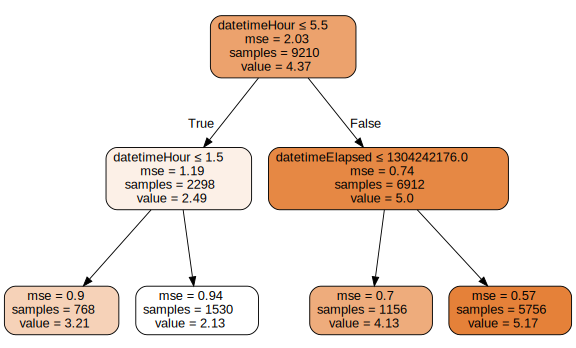

In [36]:
draw_tree(m_r, xs_r, size=8, leaves_parallel=True, precision=2)

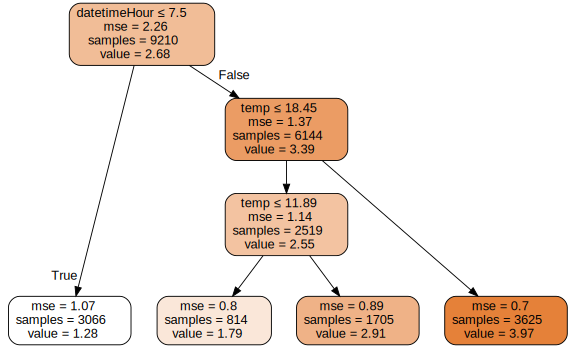

In [37]:
draw_tree(m_c, xs_c, size=8, leaves_parallel=True, precision=2)

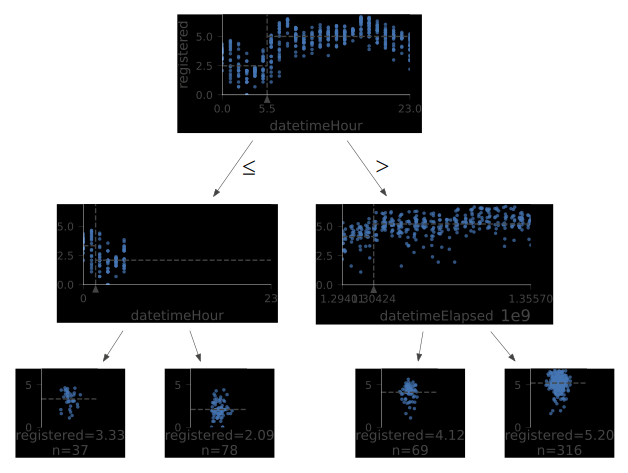

In [38]:
sampIdx = np.random.permutation(len(y_r))[:500]
dtreeviz(m_r, xs_r.iloc[sampIdx], y_r.iloc[sampIdx], xs_r.columns, depVar_r,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

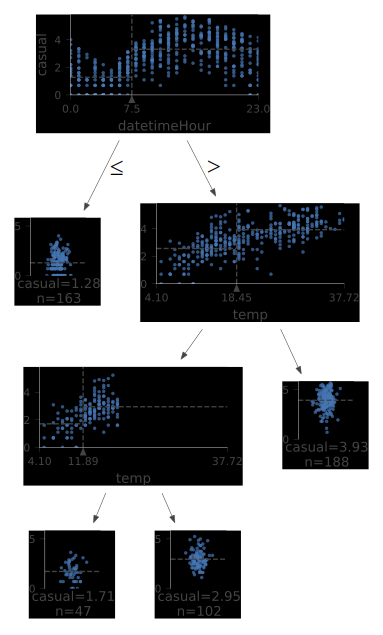

In [39]:
sampIdx = np.random.permutation(len(y_c))[:500]
dtreeviz(m_c, xs_c.iloc[sampIdx], y_c.iloc[sampIdx], xs_c.columns, depVar_c,
         scale=1.8, label_fontsize=10, orientation='TB', fontname='DejaVu Sans')

Now build bigger tree algorithm, so don't pass in `max_leaf_nodes`,

In [40]:
m_r = DecisionTreeRegressor()
m_r.fit(xs_r, y_r)
m_c = DecisionTreeRegressor()
m_c.fit(xs_c, y_c)

DecisionTreeRegressor()

Now we'll create a function for the root mean squared error, `m_rmse`, because the competition was judged using the RMSLE (root mean squared log error) as the metric so since our counts are already the `log(counts)` using RMSE here is doing RMSLE.

In [41]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [42]:
print('registered: ', m_rmse(m_r, xs_r, y_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c))

registered:  0.0
casual:      0.0


Error is 0.0, i.e. model has perfectly fit training data because we gave it unlimited leaf nodes. Check valid to see if model is overfitting, which it obviously is,

In [43]:
print('registered: ', m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, validXs_c, validY_c))

registered:  0.486579
casual:      0.71262


So we are overfitting, because we have nearly as many leaf nodes as data points,

In [44]:
print('registered: ', m_r.get_n_leaves(), len(xs_r))
print('casual:     ', m_c.get_n_leaves(), len(xs_c))

registered:  8433 9210
casual:      7540 9210


Change stopping rule to have more data points in each leaf node,

In [45]:
m_r = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)
m_c = DecisionTreeRegressor(min_samples_leaf=minLeafSamp)

m_r.fit(to_r.train.xs, to_r.train.y)
m_c.fit(to_c.train.xs, to_c.train.y)

print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.0 0.500585
casual:      0.0 0.710847


In [46]:
print('registered: ', m_r.get_n_leaves())
print('casual:     ', m_c.get_n_leaves())

registered:  8434
casual:      7545


### Creating a Random Forest

In [47]:
def rf(xs, y, n_estimators=1000, max_samples=None, max_features=0.5,
       min_samples_leaf=minLeafSamp, **kwargs):
    return RandomForestRegressor(n_jobs=-1,
                                 n_estimators=n_estimators,
                                 max_samples=max_samples,
                                 max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=True
                                ).fit(xs, y)

In [48]:
m_r = rf(xs_r, y_r)
m_c = rf(xs_c, y_c)

In [49]:
print('registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))

registered:  0.112184 0.332485
casual:      0.169575 0.522298


Get the predictions from each individual tree in our forest, which are in the `n_estimators_` attribute, 

In [50]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
print('registered: ', r_mse(preds_r.mean(0), validY_r)) # mean is the same as whole forest above
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])
print('casual:     ', r_mse(preds_c.mean(0), validY_c)) # mean is the same as whole forest above

registered:  0.332485
casual:      0.522298


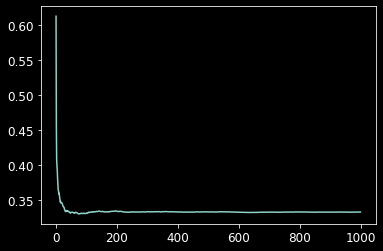

In [51]:
plt.plot([r_mse(preds_r[:i+1].mean(0), validY_r) for i in range(len(preds_r))]);

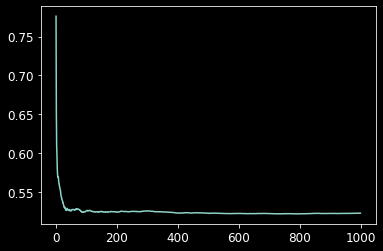

In [52]:
plt.plot([r_mse(preds_c[:i+1].mean(0), validY_c) for i in range(len(preds_c))]);

Out-of-Bag Error

In [53]:
print('train/valid registered: ', m_rmse(m_r, xs_r, y_r), m_rmse(m_r, validXs_r, validY_r))
print('train/valid casual:     ', m_rmse(m_c, xs_c, y_c), m_rmse(m_c, validXs_c, validY_c))
print('OOB         registered: ', r_mse(m_r.oob_prediction_, y_r))
print('OOB         casual:     ', r_mse(m_c.oob_prediction_, y_c))

train/valid registered:  0.112184 0.332485
train/valid casual:      0.169575 0.522298
OOB         registered:  0.304972
OOB         casual:      0.460841


OOB error being about equal to higher than validation error means that our model is generalizing slightly better to the validation set than it is to the rest of training set.

OOB error being lower than our validation error means that something else is causing that error, in addition to normal generalization error. 

## Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!

### Tree Variance for Prediction Confidence

In [54]:
preds_r = np.stack([t.predict(validXs_r) for t in m_r.estimators_])
preds_c = np.stack([t.predict(validXs_c) for t in m_c.estimators_])

In [55]:
print('registered: ', preds_r.shape)
print('casual:     ', preds_c.shape)

registered:  (1000, 1718)
casual:      (1000, 1718)


In [56]:
predsSD_r = preds_r.std(0)
predsSD_c = preds_c.std(0)

In [57]:
print('registered: ', predsSD_r[:10])
print('casual:     ', predsSD_c[:10])

registered:  [0.72899382 0.88481685 1.03772811 0.898532   0.71962724 0.66922465 1.24430358 1.21348464 1.04102476 0.72917954]
casual:      [0.64398413 0.64551125 0.68532339 0.62277718 0.55930231 0.53486691 0.53079206 0.68599273 0.8142791  0.81289392]


Some predictions are more confident than others based on whether most trees agree or not. This can be seen by varying magnitudes of standard deviation.

### Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [58]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [59]:
fi_r = rf_feat_importance(m_r, xs_r)
fi_r[:10]

,cols,imp
22,datetimeHour,0.704029
23,datetimeElapsed,0.070213
17,humidity,0.035645
6,datetimeDayofweek,0.033106
16,atemp,0.032037
2,workingday,0.029414
15,temp,0.028838
21,datetimeDayofyear,0.017535
4,datetimeYear,0.009152
18,windspeed,0.008729


In [60]:
fi_c = rf_feat_importance(m_c, xs_c)
fi_c[:10]

,cols,imp
22,datetimeHour,0.493425
16,atemp,0.133496
15,temp,0.110869
17,humidity,0.051207
21,datetimeDayofyear,0.037628
23,datetimeElapsed,0.037230
2,workingday,0.033066
6,datetimeDayofweek,0.026385
19,datetimeWeek,0.019779
3,weather,0.013988


In [61]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

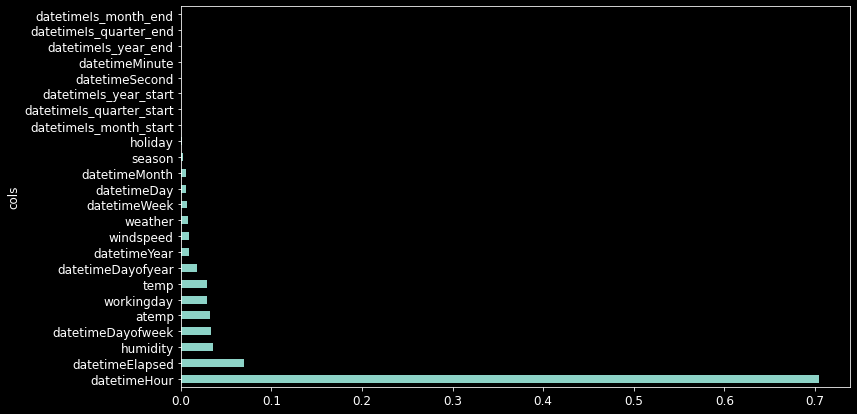

In [62]:
plot_fi(fi_r[:]);

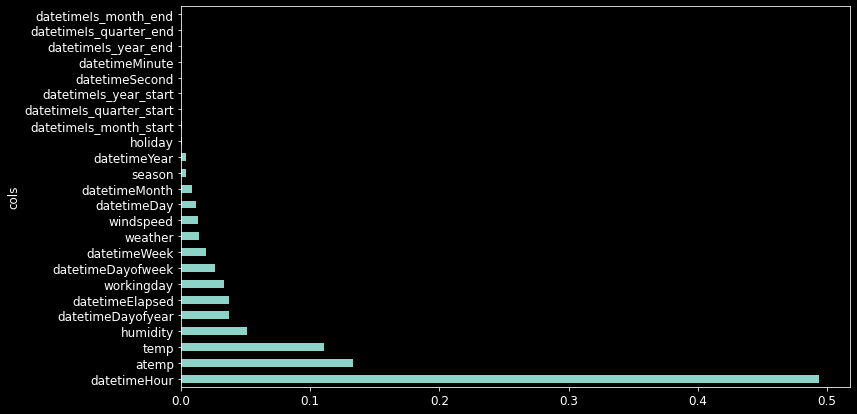

In [63]:
plot_fi(fi_c[:]);

For both `registered` and `casual` rentals `datetimeHour` was by far the most important factor which makes sense. `registered` rentals are completely dominated by the `datetimeHour` whereas `casual` rentals have a bit more spread out importance with `temp` and `atemp`.

I think it's promising to see that these two types of rentals indeed have different feature importances. I think this means that separating their predictions will be beneficial.

### Remove Low-Importance Variables

The following columns will be dropped:

In [64]:
print('registered: \n', fi_r[fi_r.imp<=0.0005].cols, sep='')
print('\n')
print('casual:     \n', fi_c[fi_c.imp<=0.0005].cols, sep='')

registered: 
8       datetimeIs_month_start
10    datetimeIs_quarter_start
12       datetimeIs_year_start
14              datetimeSecond
13              datetimeMinute
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


casual:     
10    datetimeIs_quarter_start
12       datetimeIs_year_start
14              datetimeSecond
13              datetimeMinute
11         datetimeIs_year_end
9       datetimeIs_quarter_end
7         datetimeIs_month_end
Name: cols, dtype: object


The following columns will be kept:

In [65]:
toKeep_r = fi_r[fi_r.imp>0.0005].cols
toKeep_c = fi_c[fi_c.imp>0.0005].cols
print('registered: \n', toKeep_r, sep='')
print('\n')
print('casual:     \n', toKeep_c, sep='')

registered: 
22         datetimeHour
23      datetimeElapsed
17             humidity
6     datetimeDayofweek
16                atemp
2            workingday
15                 temp
21    datetimeDayofyear
4          datetimeYear
18            windspeed
3               weather
19         datetimeWeek
20          datetimeDay
5         datetimeMonth
0                season
1               holiday
Name: cols, dtype: object


casual:     
22              datetimeHour
16                     atemp
15                      temp
17                  humidity
21         datetimeDayofyear
23           datetimeElapsed
2                 workingday
6          datetimeDayofweek
19              datetimeWeek
3                    weather
18                 windspeed
20               datetimeDay
5              datetimeMonth
0                     season
4               datetimeYear
1                    holiday
8     datetimeIs_month_start
Name: cols, dtype: object


I think I need to make two different test sets here because the important variables are different and I need to drop different columns for the two different predictions,

In [66]:
xsImp_r = xs_r[toKeep_r]
xsImp_c = xs_c[toKeep_c]

validXsImp_r = validXs_r[toKeep_r]
validXsImp_c = validXs_c[toKeep_c]

testXsImp_r = testXs[toKeep_r]
testXsImp_c = testXs[toKeep_c]

In [67]:
print(xsImp_r.columns == validXsImp_r.columns)
print(xsImp_r.columns == testXsImp_r.columns)

print(xsImp_c.columns == validXsImp_c.columns)
print(xsImp_c.columns == testXsImp_c.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True]


All columns for training, validation, and testing are the same for `registered` and `casual` respectively.

In [68]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

In [69]:
print('Error after importance filtering:')
print('registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

Error after importance filtering:
registered:  0.112416 0.334733
casual:      0.169493 0.524932


Our accuracy is about the same, even a bit better, and now our model is simpler to train.

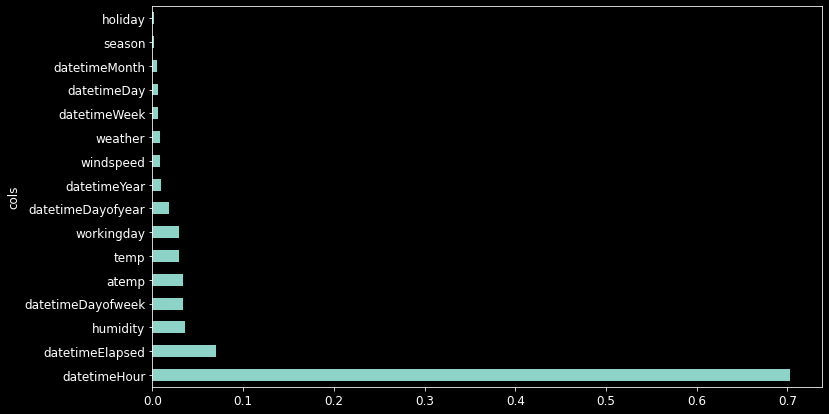

In [70]:
plot_fi(rf_feat_importance(m_r, xsImp_r));

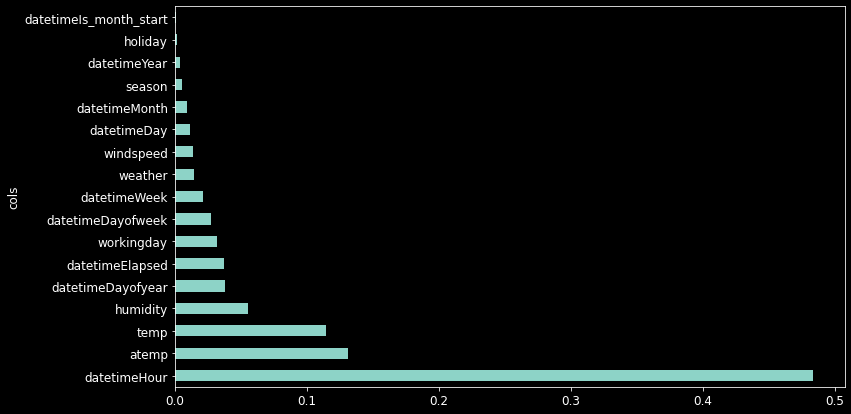

In [71]:
plot_fi(rf_feat_importance(m_c, xsImp_c));

### Remove Redundant Features

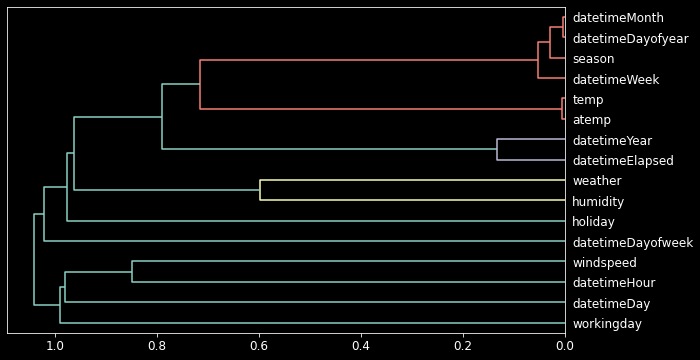

In [72]:
cluster_columns(xsImp_r)

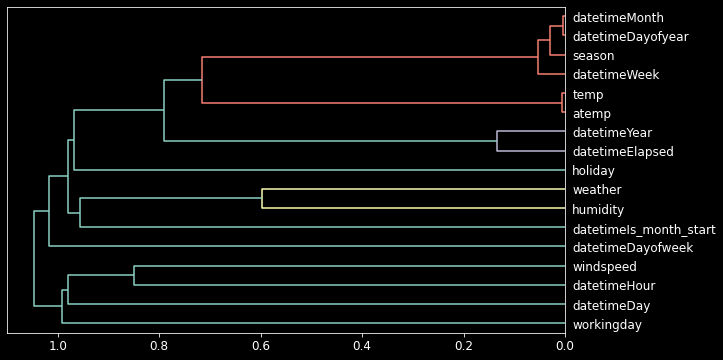

In [73]:
cluster_columns(xsImp_c)

We could try removing `datetimeMonth / datetimeDayofyear` and `temp / atemp`,

In [74]:
def get_oob(df, y):
    #m = RandomForestRegressor(n_estimators=80, min_samples_leaf=15, max_samples=None,
    #                          max_features=0.5, n_jobs=-1, oob_score=True)
    #m.fit(df, y)
    m = rf(df, y, max_samples=None)
    
    return m.oob_score_

In [75]:
print('Baseline OOB scores')
print('registered: ', get_oob(xsImp_r, y_r))
print('casual:     ', get_oob(xsImp_c, y_c))

Baseline OOB scores
registered:  0.9541583637266708
casual:      0.9059063909624301


In [76]:
print('registered:')
{c:get_oob(xsImp_r.drop(c, axis=1), y_r) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

registered:


{'temp': 0.9537436804644808,
 'atemp': 0.9535499375093707,
 'datetimeMonth': 0.9528648076495891,
 'datetimeDayofyear': 0.9532291316024797}

The OOB score is potentially slightly higher when dropping `atemp` or `datetimeDayofyear` but those changes are so small that rerunning sometimes makes them lower.

In [77]:
toDrop_r = []

In [78]:
print('casual:')
{c:get_oob(xsImp_c.drop(c, axis=1), y_c) for c in ('temp', 'atemp', 'datetimeMonth', 'datetimeDayofyear')}

casual:


{'temp': 0.9060479446546854,
 'atemp': 0.9067151679566123,
 'datetimeMonth': 0.905795953177526,
 'datetimeDayofyear': 0.9059211950949222}

The OOB score for dropping `atemp` from `casual` is consistently about three thousandths higher than the original OOB score.

In [79]:
toDrop_c = ['atemp']

In [80]:
print('registered: \n', xsImp_r.columns, sep='')
print('\n')
print('casual:     \n', xsImp_c.columns, sep='')

registered: 
Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
       'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
       'windspeed', 'weather', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
       'season', 'holiday'],
      dtype='object')


casual:     
Index(['datetimeHour', 'atemp', 'temp', 'humidity', 'datetimeDayofyear',
       'datetimeElapsed', 'workingday', 'datetimeDayofweek', 'datetimeWeek',
       'weather', 'windspeed', 'datetimeDay', 'datetimeMonth', 'season',
       'datetimeYear', 'holiday', 'datetimeIs_month_start'],
      dtype='object')


In [81]:
print('registered: ', get_oob(xsImp_r.drop(toDrop_r, axis=1), y_r))
print('casual:     ', get_oob(xsImp_c.drop(toDrop_c, axis=1), y_c))

registered:  0.9541173891530099
casual:      0.9066790688753479


Dropping `datetimeMonth` gives a little higher OOB score for `registered` and dropping nothing keeps `casual` the same.

In [82]:
xsFinal_r = xsImp_r.drop(toDrop_r, axis=1)
xsFinal_c = xsImp_c.drop(toDrop_c, axis=1)

validXsFinal_r = validXsImp_r.drop(toDrop_r, axis=1)
validXsFinal_c = validXsImp_c.drop(toDrop_c, axis=1)

testXsFinal_r = testXsImp_r.drop(toDrop_r, axis=1)
testXsFinal_c = testXsImp_c.drop(toDrop_c, axis=1)

xsFinal_r.columns, validXsFinal_r.columns

(Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
        'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
        'windspeed', 'weather', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
        'season', 'holiday'],
       dtype='object'),
 Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
        'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
        'windspeed', 'weather', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
        'season', 'holiday'],
       dtype='object'))

In [83]:
m_r = rf(xsImp_r, y_r)
m_c = rf(xsImp_c, y_c)

print('Before registered: ', m_rmse(m_r, xsImp_r, y_r), m_rmse(m_r, validXsImp_r, validY_r))
print('Before casual:     ', m_rmse(m_c, xsImp_c, y_c), m_rmse(m_c, validXsImp_c, validY_c))

m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('After registered:  ', m_rmse(m_r, xsFinal_r, y_r), m_rmse(m_r, validXsFinal_r, validY_r))
print('After casual:      ', m_rmse(m_c, xsFinal_c, y_c), m_rmse(m_c, validXsFinal_c, validY_c))

Before registered:  0.112641 0.333366
Before casual:      0.169818 0.525466
After registered:   0.112499 0.332771
After casual:       0.16876 0.517776


Valid error is a little less for `registered` than it was before redundant feature removal which makes sense because we didn't remove anything from the `casual` dataset.

### Partial Dependence

In [84]:
to_c.classes['season']

['#na#', 1, 2, 3, 4]

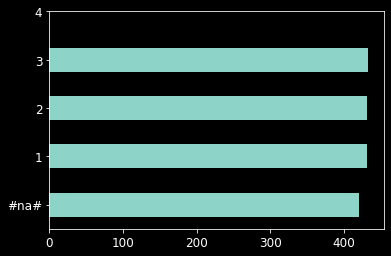

In [85]:
# all remaining variables are continuous so a bar plot doesn't really apply.
p = validXs_r['season'].value_counts(sort=False).plot.barh()
c = to_r.classes['season']
plt.yticks(ticks=range(len(c)), labels=c);

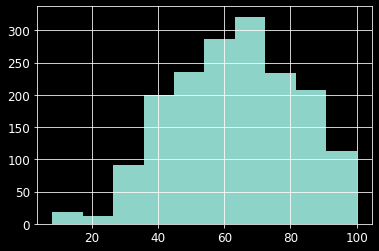

In [86]:
ax = validXsFinal_r['humidity'].hist()

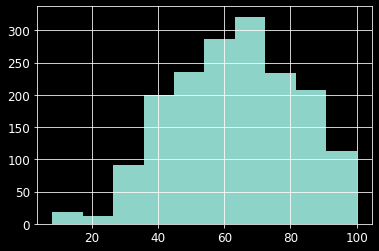

In [87]:
ax = validXsFinal_c['humidity'].hist()

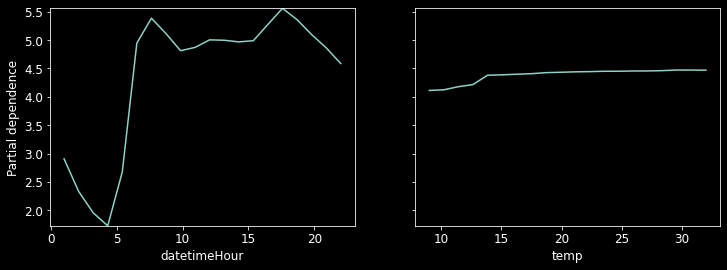

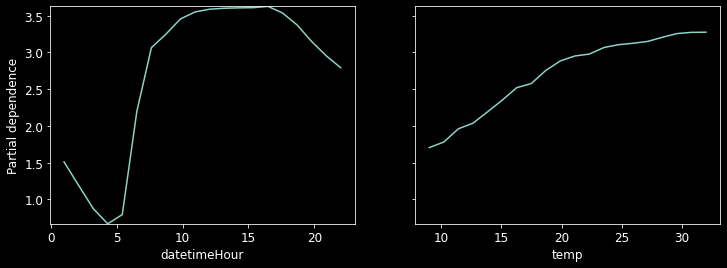

In [88]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_r, validXsFinal_r,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m_c, validXsFinal_c,
                        ['datetimeHour', 'temp'],
                        grid_resolution=20, ax=ax);

The ordinate (counts) is log-scale so a linear dependence is actually an exponential dependence.

### Tree Interpreter

In [89]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [90]:
row_r = validXsFinal_r.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_r, row_r.values)

In [91]:
prediction[0], bias[0], contributions[0].sum()

(array([2.66143273]), 4.370968542034501, -1.7095358100484557)

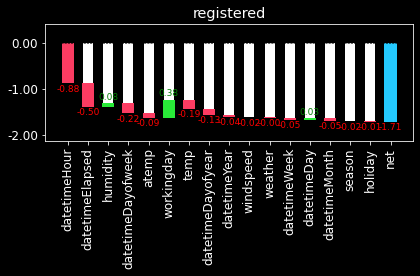

In [92]:
waterfall(validXsFinal_r.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='registered');

In [93]:
row_c = validXsFinal_c.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m_c, row_c.values)

In [94]:
prediction[0], bias[0], contributions[0].sum()

(array([0.94463314]), 2.6851114401365557, -1.7404783037449187)

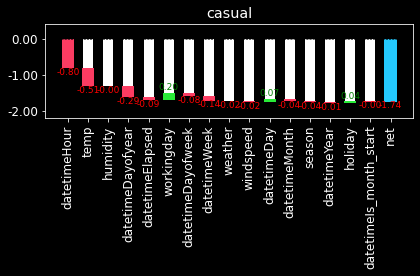

In [95]:
waterfall(validXsFinal_c.columns, contributions[0], threshold=0.001,
          rotation_value=90, formatting='{:,.2f}', Title='casual');

This information answers the question: "for predicting a particular row of data, what were the most important factors and how did they influence the prediction?"

For some of these categories the signs are flipped between `registered` and `casual`. I'm not entirely sure what that means but I'd guess that these categores have an inverse impact on count between the two types of counts which is interesting.

## Extrapolation and Neural Networks

### Finding Out-of-Domain Data

Concatenate training and validation data and label them with 0 for training and 1 for valid, then calculate importance of each column for predicting valid or not.

In [96]:
dfDom_r = pd.concat([xsFinal_r, validXsFinal_r])
isValid_r = np.array([0]*len(xsFinal_r) + [1]*len(validXsFinal_r))

dfDom_c = pd.concat([xsFinal_c, validXsFinal_c])
isValid_c = np.array([0]*len(xsFinal_c) + [1]*len(validXsFinal_c))

In [97]:
m_r = rf(dfDom_r, isValid_r)
rf_feat_importance(m_r, dfDom_r)

,cols,imp
12,datetimeDay,0.961871
7,datetimeDayofyear,0.021746
1,datetimeElapsed,0.006428
11,datetimeWeek,0.004925
13,datetimeMonth,0.002341
6,temp,0.000729
3,datetimeDayofweek,0.000543
5,workingday,0.000385
4,atemp,0.000348
8,datetimeYear,0.000283


In [98]:
m_c = rf(dfDom_c, isValid_c)
rf_feat_importance(m_c, dfDom_c)

,cols,imp
10,datetimeDay,0.963068
3,datetimeDayofyear,0.021479
4,datetimeElapsed,0.006115
7,datetimeWeek,0.004553
11,datetimeMonth,0.002250
1,temp,0.000738
6,datetimeDayofweek,0.000511
15,datetimeIs_month_start,0.000435
5,workingday,0.000321
13,datetimeYear,0.000242


These are the scores of how important each column is in determining if a given row is in the validation set or the training set.

`datetimeDay` makes sense because the validation set days are at the end of the month, i.e. 16-20 based on how I set it earlier. 

`datetimeDayofyear` makes some sense for the same reason though since it ranges from 1-354 it doesn't have the same level of predictive power for valid vs. training because the numbers don't repeat as explicitly as `datetimeDay` does.

In [99]:
print('registered:')
tuple(dfDom_r.columns)

registered:


('datetimeHour',
 'datetimeElapsed',
 'humidity',
 'datetimeDayofweek',
 'atemp',
 'workingday',
 'temp',
 'datetimeDayofyear',
 'datetimeYear',
 'windspeed',
 'weather',
 'datetimeWeek',
 'datetimeDay',
 'datetimeMonth',
 'season',
 'holiday')

In [100]:
print('casual:')
tuple(dfDom_c.columns)

casual:


('datetimeHour',
 'temp',
 'humidity',
 'datetimeDayofyear',
 'datetimeElapsed',
 'workingday',
 'datetimeDayofweek',
 'datetimeWeek',
 'weather',
 'windspeed',
 'datetimeDay',
 'datetimeMonth',
 'season',
 'datetimeYear',
 'holiday',
 'datetimeIs_month_start')

In [101]:
m_r = rf(xsFinal_r, y_r)
print('registered orig:', m_rmse(m_r, validXsFinal_r, validY_r))

categories = tuple(dfDom_r.columns)

for c in categories:
    m_r = rf(xsFinal_r.drop(c, axis=1), y_r)
    print(c, m_rmse(m_r, validXsFinal_r.drop(c, axis=1), validY_r))

registered orig: 0.334637
datetimeHour 1.245528
datetimeElapsed 0.33883
humidity 0.35503
datetimeDayofweek 0.370408
atemp 0.341459
workingday 0.360212
temp 0.338919
datetimeDayofyear 0.3383
datetimeYear 0.337364
windspeed 0.338961
weather 0.354331
datetimeWeek 0.340025
datetimeDay 0.336417
datetimeMonth 0.339116
season 0.342237
holiday 0.339024


The error is not lowered from the original value of 0.321061 by dropping any of the columns.

In [102]:
# toDrop_r = []

# xsFinal_r = xsFinal_r.drop(columns=toDrop_r)
# validXsFinal_r = validXsFinal_r.drop(columns=toDrop_r)
# testXsFinal_r = testXsFinal_r.drop(columns=toDrop_r)

In [103]:
m_c = rf(xsFinal_c, y_c)
print('casual orig:', m_rmse(m_c, validXsFinal_c, validY_c))

categories = tuple(dfDom_c.columns)

for c in categories:
    m_c = rf(xsFinal_c.drop(c, axis=1), y_c)
    print(c, m_rmse(m_c, validXsFinal_c.drop(c, axis=1), validY_c))

casual orig: 0.518416
datetimeHour 1.095064
temp 0.631853
humidity 0.561458
datetimeDayofyear 0.523093
datetimeElapsed 0.525103
workingday 0.523911
datetimeDayofweek 0.550205
datetimeWeek 0.52217
weather 0.529373
windspeed 0.523131
datetimeDay 0.509472
datetimeMonth 0.520639
season 0.521319
datetimeYear 0.520688
holiday 0.521832
datetimeIs_month_start 0.521613


From the original RMSLE of 0.514575 it get's lower aka better if we drop `datetimeDay` for the `casual` count predictions.

In [104]:
toDrop = ['datetimeDay']

xsFinal_c = xsFinal_c.drop(columns=toDrop)
validXsFinal_c = validXsFinal_c.drop(columns=toDrop)
testXsFinal_c = testXsFinal_c.drop(columns=toDrop)

Remake the model now that we've dropped columns,

In [105]:
m_r = rf(xsFinal_r, y_r)
m_c = rf(xsFinal_c, y_c)

print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.334725
casual final: 0.509214


Now predict the test set with only the random forest,

In [106]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest_r, rfPredsTest_c

(array([2.30039103, 1.79930531, 1.04653183, ..., 5.06024386, 4.70666346, 4.35910786]),
 array([0.86792182, 0.51695483, 0.48551125, ..., 1.82937298, 1.66593167, 1.36795896]))

## Using a Neural Network

In [107]:
dfNN = pd.read_csv(path/'train.csv', low_memory=False)

dfNN[depVar]   = np.log(dfNN[depVar]   + 1)
dfNN[depVar_r] = np.log(dfNN[depVar_r] + 1)
dfNN[depVar_c] = np.log(dfNN[depVar_c] + 1)

dfNN = add_datepart(dfNN, 'datetime', time=True)

In [108]:
dfNNTest = pd.read_csv(path/'test.csv', low_memory=False)
dfNNTest = add_datepart(dfNNTest, 'datetime', time=True)

In [109]:
' '.join(o for o in dfNN.columns if o.startswith('datetime'))

'datetimeYear datetimeMonth datetimeWeek datetimeDay datetimeDayofweek datetimeDayofyear datetimeIs_month_end datetimeIs_month_start datetimeIs_quarter_end datetimeIs_quarter_start datetimeIs_year_end datetimeIs_year_start datetimeHour datetimeMinute datetimeSecond datetimeElapsed'

We can use the work we did with the RF to trim unwanted columns for the NN. Here are the columns we kept for the RF,

In [110]:
print('registered:', xsFinal_r.columns, len(xsFinal_r.columns))
print('casual:    ', xsFinal_c.columns, len(xsFinal_c.columns))

registered: Index(['datetimeHour', 'datetimeElapsed', 'humidity', 'datetimeDayofweek',
       'atemp', 'workingday', 'temp', 'datetimeDayofyear', 'datetimeYear',
       'windspeed', 'weather', 'datetimeWeek', 'datetimeDay', 'datetimeMonth',
       'season', 'holiday'],
      dtype='object') 16
casual:     Index(['datetimeHour', 'temp', 'humidity', 'datetimeDayofyear',
       'datetimeElapsed', 'workingday', 'datetimeDayofweek', 'datetimeWeek',
       'weather', 'windspeed', 'datetimeMonth', 'season', 'datetimeYear',
       'holiday', 'datetimeIs_month_start'],
      dtype='object') 15


In [111]:
dfNN_r = create_missing_rows(dfNN, 'registered')

combined = pd.concat([dfNN_r, dfNNTest])

dfNNFinal_r = combined[list(xsFinal_r.columns) + [depVar_r]]
dfNNFinal_r

,datetimeHour,datetimeElapsed,humidity,datetimeDayofweek,atemp,workingday,temp,datetimeDayofyear,datetimeYear,windspeed,weather,datetimeWeek,datetimeDay,datetimeMonth,season,holiday,registered
0,0,1.293840e+09,81.0,5,14.395,0,9.84,1,2011,0.0000,1,52,1,1,1,0,2.639057
1,1,1.293844e+09,80.0,5,13.635,0,9.02,1,2011,0.0000,1,52,1,1,1,0,3.496508
2,2,1.293847e+09,80.0,5,13.635,0,9.02,1,2011,0.0000,1,52,1,1,1,0,3.332205
3,3,1.293851e+09,75.0,5,14.395,0,9.84,1,2011,0.0000,1,52,1,1,1,0,2.397895
4,4,1.293854e+09,75.0,5,14.395,0,9.84,1,2011,0.0000,1,52,1,1,1,0,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,1.356980e+09,60.0,0,12.880,1,10.66,366,2012,11.0014,2,1,31,12,1,0,NaN
6489,20,1.356984e+09,60.0,0,12.880,1,10.66,366,2012,11.0014,2,1,31,12,1,0,NaN
6490,21,1.356988e+09,60.0,0,12.880,1,10.66,366,2012,11.0014,1,1,31,12,1,0,NaN
6491,22,1.356991e+09,56.0,0,13.635,1,10.66,366,2012,8.9981,1,1,31,12,1,0,NaN


In [112]:
#dfNNFinal_r = dfNN[list(xsFinal_r.columns) + [depVar_r]]
#dfNNFinal_r

In [113]:
dfNN_c = create_missing_rows(dfNN, 'casual')

combined = pd.concat([dfNN_c, dfNNTest])

dfNNFinal_c = combined[list(xsFinal_c.columns) + [depVar_c]]
dfNNFinal_c

,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,workingday,datetimeDayofweek,datetimeWeek,weather,windspeed,datetimeMonth,season,datetimeYear,holiday,datetimeIs_month_start,casual
0,0,9.84,81.0,1,1.293840e+09,0,5,52,1,0.0000,1,1,2011,0,True,1.386294
1,1,9.02,80.0,1,1.293844e+09,0,5,52,1,0.0000,1,1,2011,0,True,2.197225
2,2,9.02,80.0,1,1.293847e+09,0,5,52,1,0.0000,1,1,2011,0,True,1.791759
3,3,9.84,75.0,1,1.293851e+09,0,5,52,1,0.0000,1,1,2011,0,True,1.386294
4,4,9.84,75.0,1,1.293854e+09,0,5,52,1,0.0000,1,1,2011,0,True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,19,10.66,60.0,366,1.356980e+09,1,0,1,2,11.0014,12,1,2012,0,False,NaN
6489,20,10.66,60.0,366,1.356984e+09,1,0,1,2,11.0014,12,1,2012,0,False,NaN
6490,21,10.66,60.0,366,1.356988e+09,1,0,1,1,11.0014,12,1,2012,0,False,NaN
6491,22,10.66,56.0,366,1.356991e+09,1,0,1,1,8.9981,12,1,2012,0,False,NaN


In [114]:
#dfNNFinal_c = dfNN[list(xsFinal_c.columns) + [depVar_c]]
#dfNNFinal_c

In [115]:
#dfNNFinalTest_r = dfNNTest[list(xsFinal_r.columns)]
#dfNNFinalTest_r

In [116]:
#dfNNFinalTest_c = dfNNTest[list(xsFinal_c.columns)]
#dfNNFinalTest_c

##### `registered`

In [117]:
contNN_r,catNN_r = cont_cat_split(dfNNFinal_r, max_card=18, dep_var=depVar_r)

In [118]:
dfNNFinal_r[catNN_r].nunique()

datetimeDayofweek     7
workingday            2
datetimeYear          2
weather               4
datetimeMonth        12
season                4
holiday               2
dtype: int64

In [119]:
dfNNFinal_r[contNN_r].nunique()

datetimeHour            24
datetimeElapsed      17382
humidity               105
atemp                   85
temp                    64
datetimeDayofyear      366
windspeed               57
datetimeWeek            53
datetimeDay             31
dtype: int64

It seems to me that some of these variables although somewhat lower in cardinality are continuous in nature.

Specifically, `datetimeDayofyear` and `datetimeWeek` are categorical in nature, though since the predicting on the test set gives errors for out of domain categorical variables let's keep `datetimeDayofyear`, `datetimeWeek`, and `datetimeDay` as `cont` variables.

In [120]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_r.remove(i)
    catNN_r.append(i)
    
print('catNN:', catNN_r)
print('contNN:', contNN_r)

catNN: ['datetimeDayofweek', 'workingday', 'datetimeYear', 'weather', 'datetimeMonth', 'season', 'holiday', 'datetimeHour']
contNN: ['datetimeElapsed', 'humidity', 'atemp', 'temp', 'datetimeDayofyear', 'windspeed', 'datetimeWeek', 'datetimeDay']


##### `casual`

In [121]:
contNN_c,catNN_c = cont_cat_split(dfNNFinal_c, max_card=18, dep_var=depVar_c)

In [122]:
dfNNFinal_c[catNN_c].nunique()

workingday                 2
datetimeDayofweek          7
weather                    4
datetimeMonth             12
season                     4
datetimeYear               2
holiday                    2
datetimeIs_month_start     2
dtype: int64

In [123]:
dfNNFinal_c[contNN_c].nunique()

datetimeHour            24
temp                    64
humidity               105
datetimeDayofyear      366
datetimeElapsed      17382
datetimeWeek            53
windspeed               57
dtype: int64

In [124]:
# for i in ['datetimeDay', 'datetimeWeek', 'datetimeDayofyear', 'datetimeHour']: # removed b/c of test set prediction errors.
for i in ['datetimeHour']:
    contNN_c.remove(i)
    catNN_c.append(i)
    
print('catNN:', catNN_c)
print('contNN:', contNN_c)

catNN: ['workingday', 'datetimeDayofweek', 'weather', 'datetimeMonth', 'season', 'datetimeYear', 'holiday', 'datetimeIs_month_start', 'datetimeHour']
contNN: ['temp', 'humidity', 'datetimeDayofyear', 'datetimeElapsed', 'datetimeWeek', 'windspeed']


Testing dataframes don't need to be checked because we altered the lists of columns themselves.

Create `TabularPandas` object in the same was as before but with `Normalize` since we're using it for an NN.

In [125]:
procsNN = [Categorify, FillMissing, Normalize]

toNN_r = TabularPandas(dfNNFinal_r,
                       procs=procs,
                       cat_names=catNN_r,
                       cont_names=contNN_r,
                       y_names=depVar_r,
                       splits=splits_r)

toNN_c = TabularPandas(dfNNFinal_c,
                       procs=procs,
                       cat_names=catNN_c,
                       cont_names=contNN_c,
                       y_names=depVar_c,
                       splits=splits_c)

#toNNtest_r = TabularPandas(dfNNFinalTest_r,
#                           procs=procs,
#                           cat_names=catNN_r,
#                           cont_names=contNN_r,
#                           splits=None)

#toNNtest_c = TabularPandas(dfNNFinalTest_c,
#                           procs=procs,
#                           cat_names=catNN_c,
#                           cont_names=contNN_c,
#                           splits=None)

In [126]:
toNN_r.show()

,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,5,0,2011,1,1,1,0,0,1.293840e+09,81.0,14.395000,9.84,1,0.0000,52,1,2.639057
1,5,0,2011,1,1,1,0,1,1.293844e+09,80.0,13.635000,9.02,1,0.0000,52,1,3.496508
2,5,0,2011,1,1,1,0,2,1.293847e+09,80.0,13.635000,9.02,1,0.0000,52,1,3.332205
3,5,0,2011,1,1,1,0,3,1.293851e+09,75.0,14.395000,9.84,1,0.0000,52,1,2.397895
4,5,0,2011,1,1,1,0,4,1.293854e+09,75.0,14.395000,9.84,1,0.0000,52,1,0.693147
5,5,0,2011,2,1,1,0,5,1.293858e+09,75.0,12.880000,9.84,1,6.0032,52,1,0.693147
6,5,0,2011,1,1,1,0,6,1.293862e+09,80.0,13.635000,9.02,1,0.0000,52,1,0.000000
7,5,0,2011,1,1,1,0,7,1.293865e+09,86.0,12.880000,8.20,1,0.0000,52,1,1.098612
8,5,0,2011,1,1,1,0,8,1.293869e+09,75.0,14.395000,9.84,1,0.0000,52,1,2.079442
9,5,0,2011,1,1,1,0,9,1.293872e+09,76.0,17.424999,13.12,1,0.0000,52,1,1.945910


Tabular models don't generally need much GPU ram so we can have bigger batch sizes,

I think creating the `TabularPandas` objects with dataframes that have both training and test data will initialize the NN such that the range of categories that are unique to the test set will not cause errors down the line.

In [127]:
toTrainNN_r = TabularPandas(dfNNFinal_r[:len(dfNN_r)],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                            splits=splits_r
                           )
toTrainNN_r.show()

toTestNN_r = TabularPandas(dfNNFinal_r[len(dfNN_r):],
                            procs=procs,
                            cat_names=catNN_r,
                            cont_names=contNN_r,
                            y_names=depVar_r,
                           )
toTestNN_r.show()

,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,5,0,2011,1,1,1,0,0,1.293840e+09,81.0,14.395000,9.84,1,0.0000,52,1,2.639057
1,5,0,2011,1,1,1,0,1,1.293844e+09,80.0,13.635000,9.02,1,0.0000,52,1,3.496508
2,5,0,2011,1,1,1,0,2,1.293847e+09,80.0,13.635000,9.02,1,0.0000,52,1,3.332205
3,5,0,2011,1,1,1,0,3,1.293851e+09,75.0,14.395000,9.84,1,0.0000,52,1,2.397895
4,5,0,2011,1,1,1,0,4,1.293854e+09,75.0,14.395000,9.84,1,0.0000,52,1,0.693147
5,5,0,2011,2,1,1,0,5,1.293858e+09,75.0,12.880000,9.84,1,6.0032,52,1,0.693147
6,5,0,2011,1,1,1,0,6,1.293862e+09,80.0,13.635000,9.02,1,0.0000,52,1,0.000000
7,5,0,2011,1,1,1,0,7,1.293865e+09,86.0,12.880000,8.20,1,0.0000,52,1,1.098612
8,5,0,2011,1,1,1,0,8,1.293869e+09,75.0,14.395000,9.84,1,0.0000,52,1,2.079442
9,5,0,2011,1,1,1,0,9,1.293872e+09,76.0,17.424999,13.12,1,0.0000,52,1,1.945910


,datetimeDayofweek,workingday,datetimeYear,weather,datetimeMonth,season,holiday,datetimeHour,datetimeElapsed,humidity,atemp,temp,datetimeDayofyear,windspeed,datetimeWeek,datetimeDay,registered
0,3,1,2011,1,1,1,0,0,1.295482e+09,56.0,11.365,10.66,20,26.002701,3,20,NaN
1,3,1,2011,1,1,1,0,1,1.295485e+09,56.0,13.635,10.66,20,0.000000,3,20,NaN
2,3,1,2011,1,1,1,0,2,1.295489e+09,56.0,13.635,10.66,20,0.000000,3,20,NaN
3,3,1,2011,1,1,1,0,3,1.295492e+09,56.0,12.880,10.66,20,11.001400,3,20,NaN
4,3,1,2011,1,1,1,0,4,1.295496e+09,56.0,12.880,10.66,20,11.001400,3,20,NaN
5,3,1,2011,1,1,1,0,5,1.295500e+09,60.0,11.365,9.84,20,15.001300,3,20,NaN
6,3,1,2011,1,1,1,0,6,1.295503e+09,60.0,10.605,9.02,20,15.001300,3,20,NaN
7,3,1,2011,1,1,1,0,7,1.295507e+09,55.0,10.605,9.02,20,15.001300,3,20,NaN
8,3,1,2011,1,1,1,0,8,1.295510e+09,55.0,10.605,9.02,20,19.001200,3,20,NaN
9,3,1,2011,2,1,1,0,9,1.295514e+09,52.0,11.365,9.84,20,15.001300,3,20,NaN


In [128]:
toTrainNN_c = TabularPandas(dfNNFinal_c[:len(dfNN_c)],
                            procs=procs,
                            cat_names=catNN_c,
                            cont_names=contNN_c,
                            y_names=depVar_c,
                            splits=splits_c
                           )
toTrainNN_c.show()

toTestNN_c = TabularPandas(dfNNFinal_c[len(dfNN_c):],
                           procs=procs,
                           cat_names=catNN_c,
                           cont_names=contNN_c,
                           y_names=depVar_c,
                          )
toTestNN_c.show()

,workingday,datetimeDayofweek,weather,datetimeMonth,season,datetimeYear,holiday,datetimeIs_month_start,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,windspeed,casual
0,0,5,1,1,1,2011,0,True,0,9.84,81.0,1,1.293840e+09,52,0.0000,1.386294
1,0,5,1,1,1,2011,0,True,1,9.02,80.0,1,1.293844e+09,52,0.0000,2.197225
2,0,5,1,1,1,2011,0,True,2,9.02,80.0,1,1.293847e+09,52,0.0000,1.791759
3,0,5,1,1,1,2011,0,True,3,9.84,75.0,1,1.293851e+09,52,0.0000,1.386294
4,0,5,1,1,1,2011,0,True,4,9.84,75.0,1,1.293854e+09,52,0.0000,0.000000
5,0,5,2,1,1,2011,0,True,5,9.84,75.0,1,1.293858e+09,52,6.0032,0.000000
6,0,5,1,1,1,2011,0,True,6,9.02,80.0,1,1.293862e+09,52,0.0000,1.098612
7,0,5,1,1,1,2011,0,True,7,8.20,86.0,1,1.293865e+09,52,0.0000,0.693147
8,0,5,1,1,1,2011,0,True,8,9.84,75.0,1,1.293869e+09,52,0.0000,0.693147
9,0,5,1,1,1,2011,0,True,9,13.12,76.0,1,1.293872e+09,52,0.0000,2.197225


,workingday,datetimeDayofweek,weather,datetimeMonth,season,datetimeYear,holiday,datetimeIs_month_start,datetimeHour,temp,humidity,datetimeDayofyear,datetimeElapsed,datetimeWeek,windspeed,casual
0,1,3,1,1,1,2011,0,False,0,10.66,56.0,20,1.295482e+09,3,26.002701,NaN
1,1,3,1,1,1,2011,0,False,1,10.66,56.0,20,1.295485e+09,3,0.000000,NaN
2,1,3,1,1,1,2011,0,False,2,10.66,56.0,20,1.295489e+09,3,0.000000,NaN
3,1,3,1,1,1,2011,0,False,3,10.66,56.0,20,1.295492e+09,3,11.001400,NaN
4,1,3,1,1,1,2011,0,False,4,10.66,56.0,20,1.295496e+09,3,11.001400,NaN
5,1,3,1,1,1,2011,0,False,5,9.84,60.0,20,1.295500e+09,3,15.001300,NaN
6,1,3,1,1,1,2011,0,False,6,9.02,60.0,20,1.295503e+09,3,15.001300,NaN
7,1,3,1,1,1,2011,0,False,7,9.02,55.0,20,1.295507e+09,3,15.001300,NaN
8,1,3,1,1,1,2011,0,False,8,9.02,55.0,20,1.295510e+09,3,19.001200,NaN
9,1,3,2,1,1,2011,0,False,9,9.84,52.0,20,1.295514e+09,3,15.001300,NaN


In [129]:
print('Y-ranges for each set:')
y_r = toNN_r.train.y
print('registered:', y_r.min(), y_r.max())
y_c = toNN_c.train.y
print('casual:', y_c.min(), y_c.max())

Y-ranges for each set:
registered: 0.0 6.787845
casual: 0.0 5.894403


In [130]:
dls_r = toTrainNN_r.dataloaders(bs=1024)
dls_c = toTrainNN_c.dataloaders(bs=1024)

learn_r = tabular_learner(dls_r, layers=[layer1,layer2,layer3], n_out=1,
                         y_range=(0,7), loss_func=F.mse_loss)
learn_c = tabular_learner(dls_c, layers=[layer1,layer2,layer3], n_out=1,
                         y_range=(0,6), loss_func=F.mse_loss)

registered:
lrMin/10: 0.014454397559165954 lrSteep: 0.0010000000474974513


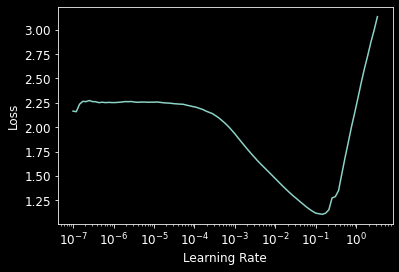

In [131]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.012022644281387329 lrSteep: 0.0012022644514217973


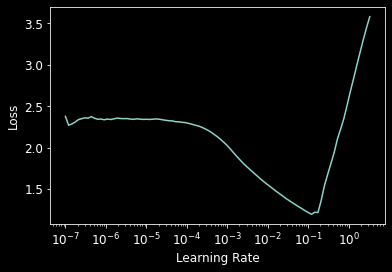

In [132]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

epoch,train_loss,valid_loss,time
0,1.238567,1.741340,00:00
1,0.759867,2.997008,00:00
2,0.526996,2.379685,00:00
3,0.399265,1.791919,00:00
4,0.318760,1.491911,00:00
5,0.265306,0.914644,00:00
6,0.225425,0.508239,00:00
7,0.195659,0.233700,00:00
8,0.173199,0.131159,00:00
9,0.154544,0.096869,00:00


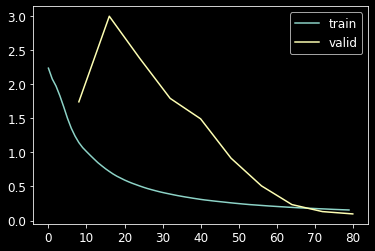

In [133]:
learn_r.fit_one_cycle(trainEpochs1_r, lr_max=lrMin_r)
learn_r.recorder.plot_loss(skip_start=0)

epoch,train_loss,valid_loss,time
0,1.504988,3.190238,00:00
1,0.940869,4.171848,00:00
2,0.707816,1.327462,00:00
3,0.571969,1.270567,00:00
4,0.484437,1.178613,00:00
5,0.420082,0.948254,00:00
6,0.374371,0.549986,00:00
7,0.338704,0.387901,00:00
8,0.310388,0.311731,00:00
9,0.286731,0.275703,00:00


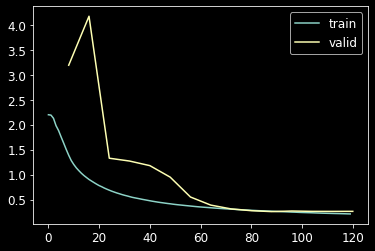

In [134]:
learn_c.fit_one_cycle(trainEpochs1_c, lr_max=lrMin_c)
learn_c.recorder.plot_loss(skip_start=0)

registered:
lrMin/10: 1.0964781722577755e-07 lrSteep: 6.309573450380412e-07


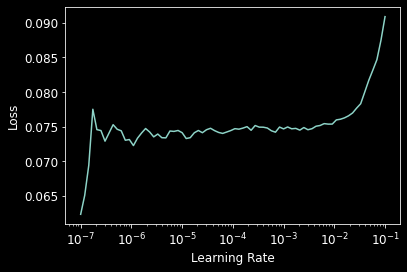

In [135]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 0.00012022644514217973 lrSteep: 7.585775847473997e-07


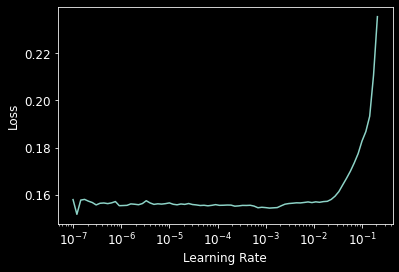

In [136]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

epoch,train_loss,valid_loss,time
0,0.072945,0.091709,00:00
1,0.075639,0.091432,00:00
2,0.075088,0.091432,00:00
3,0.076035,0.091673,00:00
4,0.075375,0.092083,00:00
5,0.075580,0.091978,00:00
6,0.075229,0.091985,00:00
7,0.075553,0.091985,00:00
8,0.075423,0.092030,00:00
9,0.075917,0.092188,00:00


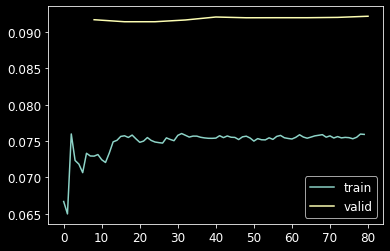

In [137]:
learn_r.fit_one_cycle(trainEpochs2_r, lr_max=lrMin_r)
learn_r.recorder.plot_loss(skip_start=0)

epoch,train_loss,valid_loss,time
0,0.156476,0.263348,00:00
1,0.158677,0.263629,00:00
2,0.156663,0.263520,00:00
3,0.156684,0.263103,00:00
4,0.155544,0.262159,00:00
5,0.155218,0.263239,00:00
6,0.155548,0.264299,00:00
7,0.155640,0.264197,00:00
8,0.155852,0.263514,00:00
9,0.156227,0.264401,00:00


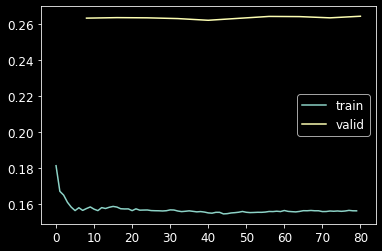

In [138]:
learn_c.fit_one_cycle(trainEpochs2_c, lr_max=lrMin_c)
learn_c.recorder.plot_loss(skip_start=0)

registered:
lrMin/10: 4.786300996784121e-05 lrSteep: 2.2908675418875646e-06


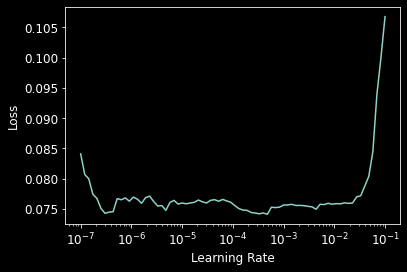

In [139]:
lrMin_r,lrSteep_r = learn_r.lr_find()
print('registered:')
print('lrMin/10:', lrMin_r, 'lrSteep:', lrSteep_r)

casual:
lrMin/10: 4.365158383734525e-06 lrSteep: 3.630780702224001e-05


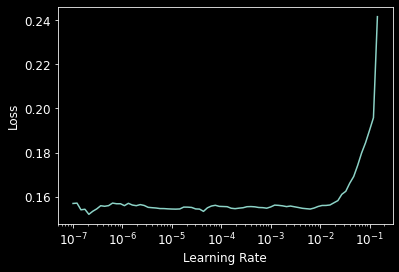

In [140]:
lrMin_c,lrSteep_c = learn_c.lr_find()
print('casual:')
print('lrMin/10:', lrMin_c, 'lrSteep:', lrSteep_c)

## Ensembling

### Validation Set

The averaging of the scores must be done in the linear state of the count variables.

In [141]:
rfPreds_r = m_r.predict(validXsFinal_r)
rfPreds_c = m_c.predict(validXsFinal_c)

nnPreds_r,nnTargs_r = learn_r.get_preds()
nnPreds_c,nnTargs_c = learn_c.get_preds()

ensPreds_r = np.log( (np.exp(to_np(nnPreds_r.squeeze())) - 1 + np.exp(rfPreds_r) - 1)/2 + 1)
ensPreds_c = np.log( (np.exp(to_np(nnPreds_c.squeeze())) - 1 + np.exp(rfPreds_c) - 1)/2 + 1)

In [142]:
print('Random Forest Final Results')
print('registered final:', m_rmse(m_r, validXsFinal_r, validY_r))
print('casual final:', m_rmse(m_c, validXsFinal_c, validY_c))

Random Forest Final Results
registered final: 0.334725
casual final: 0.509214


In [143]:
print('Neural Network Final Results')
print('registered:', r_mse(nnPreds_r, nnTargs_r))
print('casual:    ', r_mse(nnPreds_c, nnTargs_c))

Neural Network Final Results
registered: 0.303625
casual:     0.514199


In [144]:
print('Ensembled RF/NN Final Results')
print('registered:', r_mse(ensPreds_r, validY_r))
print('casaul:    ', r_mse(ensPreds_c, validY_c))

Ensembled RF/NN Final Results
registered: 0.299062
casaul:     0.492035


An important note is that we're not averaging the errors here, we're averaging the predictions. This is why we can go from `registered` error of 0.32141 and 0.282413 for RF and NN respectively to an ensembled error of 0.282106. 

------

## Convert to `counts`

Now to get the validation error for the total `counts`, to convert my `y_r` and `y_c` into `y_total`.
$$
y_t = \log(e^{y_r} + e^{y_c} - 1)
$$

The `y` values above are `np.log(counts + 1)`.

In [145]:
print('Total count Final Results')
#print('count:', r_mse(ensPreds, y))

y_t = np.log( np.exp(y_r) + np.exp(y_c) - 1 )

y_t

Total count Final Results


0        2.833213
1        3.713572
2        3.496508
3        2.639057
4        0.693147
           ...   
10851    4.700480
10852    4.812184
10853    4.672829
10854    4.499810
10855    3.526361
Length: 9210, dtype: float32

The original `y` aka `log(counts + 1)` are the same as `y_t` so this is how we can combine the predictions later. 

Now need to convert the predictions to an array of `counts`. Do this by exponentiating and then subtracting 1 and then summing the resulting values.

In [146]:
ensPreds = np.log( np.exp(ensPreds_r) + np.exp(ensPreds_c) - 1 )
ensPreds = np.exp(ensPreds) - 1
ensPreds

array([ 14.17448745,   9.20224297,   5.04240482, ..., 195.92296687, 149.31984577, 101.75932522])

Make subroutine to perform the conversion,

In [147]:
def convert_to_counts(log_r, log_c):
    counts = np.exp(log_r) + np.exp(log_c) - 2
    return counts

convert_to_counts(ensPreds_r, ensPreds_c) # test that it returns same as above

array([ 14.17448745,   9.20224297,   5.04240482, ..., 195.92296687, 149.31984577, 101.75932522])

## Predict test set

Do I write the predictions as `count` or as `np.log(count+1)` when submitting to Kaggle? I think `count`.

### Random Forest Predictions

Predicting the test set targets is simple, just use the `.predict()` method,

In [148]:
rfPredsTest_r = m_r.predict(testXsFinal_r)
rfPredsTest_c = m_c.predict(testXsFinal_c)

rfPredsTest = convert_to_counts(rfPredsTest_r, rfPredsTest_c)

rfPredsTest

array([ 10.36003896,   5.72235968,   2.47276305, ..., 161.8589304 , 113.97284725,  80.11467608])

### Neural Network Predictions

Predicting the test set with a NN is more complicated. The original dataframe that the `tabular_learner` is trained on must also contain the test set data, not be trained on the test data but it must contain the data so that the learner knows the cardinality of all columns. Then the `.dls.test_dl()` method can be used along with `.get_preds()` to calculate the predictions for the test set,

In [149]:
dlTest_r = learn_r.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_r,_ = learn_r.get_preds(dl=dlTest_r)

nnPredsTest_r = to_np( nnPredsTest_r.squeeze() )

nnPredsTest_r

array([2.3462539, 1.6856687, 1.1000645, ..., 4.9370203, 4.5780835, 4.062763 ], dtype=float32)

In [150]:
dlTest_c = learn_c.dls.test_dl(dfNNTest, bs=1024)
nnPredsTest_c,_ = learn_c.get_preds(dl=dlTest_c)

nnPredsTest_c = to_np( nnPredsTest_c.squeeze() )

nnPredsTest_c

array([0.36883873, 0.32798377, 0.23676838, ..., 1.8242393 , 1.4411035 , 0.994532  ], dtype=float32)

In [151]:
nnPredsTest = convert_to_counts(nnPredsTest_r, nnPredsTest_c)
nnPredsTest

array([  9.892417 ,   4.7842245,   2.2715073, ..., 143.55247  ,  99.55304  ,  58.83819  ], dtype=float32)

### Ensemble Test Set Predictions

In [152]:
ensPredsTest = (rfPredsTest + nnPredsTest)/2
ensPredsTest

array([ 10.12622796,   5.2532921 ,   2.37213516, ..., 152.70570269, 106.7629434 ,  69.47643212])

------

## Create Submission File

Now we have the converted counts for random forest, neural network, and ensembled test set predictions. Recall that we previously saved the test set `datetime` column as `datetimeTest` so let's take a look at that,

### Generate datetime

In [153]:
datetimeTest

0       2011-01-20 00:00:00
1       2011-01-20 01:00:00
2       2011-01-20 02:00:00
3       2011-01-20 03:00:00
4       2011-01-20 04:00:00
               ...         
6488    2012-12-31 19:00:00
6489    2012-12-31 20:00:00
6490    2012-12-31 21:00:00
6491    2012-12-31 22:00:00
6492    2012-12-31 23:00:00
Name: datetime, Length: 6493, dtype: object

Judging from the sample submission file on the Kaggle page, https://www.kaggle.com/c/bike-sharing-demand/data

The submission format for the prediction rows should be the following:
```
YYYY-MM-DD hh:mm:ss,count
```

with the first three columns (first being the header column) being:
```
datetime,count
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
```

In [154]:
print(datetimeTest[0])
print(datetimeTest[1])

2011-01-20 00:00:00
2011-01-20 01:00:00


Looks like we are good to go with the datetime column.

In [155]:
def write_submission_csv(filename, datetimeCol, predCol):
    f = open(filename, 'w')
    f.write('{},{}\n'.format('datetime', 'count'))
    for i in range(len(datetimeCol)):
        f.write('{},{}\n'.format(datetimeCol[i], predCol[i]))

### Random Forest

In [156]:
write_submission_csv('rf_submit.csv', datetimeTest, rfPredsTest)

!head rf_submit.csv

datetime,count
2011-01-20 00:00:00,10.360038963872654
2011-01-20 01:00:00,5.722359679816197
2011-01-20 02:00:00,2.4727630487882113
2011-01-20 03:00:00,1.3242712166496249
2011-01-20 04:00:00,1.369955215894041
2011-01-20 05:00:00,4.131634364247191
2011-01-20 06:00:00,27.521425913871784
2011-01-20 07:00:00,80.5410044264151
2011-01-20 08:00:00,149.01041241976105


### Neural Network

In [157]:
write_submission_csv('nn_submit.csv', datetimeTest, nnPredsTest)
    
!head nn_submit.csv

datetime,count
2011-01-20 00:00:00,9.892416954040527
2011-01-20 01:00:00,4.784224510192871
2011-01-20 02:00:00,2.2715072631835938
2011-01-20 03:00:00,1.454782485961914
2011-01-20 04:00:00,1.3120107650756836
2011-01-20 05:00:00,5.01780891418457
2011-01-20 06:00:00,30.117313385009766
2011-01-20 07:00:00,76.3961410522461
2011-01-20 08:00:00,168.7356414794922


### Ensemble

In [158]:
write_submission_csv('ens_submit.csv', datetimeTest, ensPredsTest)
    
!head ens_submit.csv

datetime,count
2011-01-20 00:00:00,10.12622795895659
2011-01-20 01:00:00,5.253292095004534
2011-01-20 02:00:00,2.3721351559859025
2011-01-20 03:00:00,1.3895268513057695
2011-01-20 04:00:00,1.3409829904848622
2011-01-20 05:00:00,4.5747216392158805
2011-01-20 06:00:00,28.819369649440773
2011-01-20 07:00:00,78.4685727393306
2011-01-20 08:00:00,158.87302694962662
